In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
import statsmodels.api as sm
import scipy.stats as stats
import pandas as pd
import pickle
import mplfinance as mpf
from datetime import datetime, timedelta

In [106]:
df = dd.read_csv("orders.csv", dtype = {
        "id" : "int", 
        "timestamp" : "int", 
        "market" : "category",
        "pair" : "str",
        "side" : "category",
        "quantity" : "float",
        "price" : "float",
        "order_type" : "category",
        "execution_time" : "float"
    }
)

## 02 Statistical Analysis

### (a) Identify any outliers in trade quantity and execution times

Checking for missing values

In [107]:
print(df.loc[:, "quantity"].isna().sum().compute())
print(df.loc[:, "execution_time"].isna().sum().compute())

0
0


Grouping into quantiles

In [108]:
quantity_q = df.loc[:, "quantity"].quantile(np.arange(.05, 1, .05)).compute()
exectime_q = df.loc[:, "execution_time"].quantile(np.arange(.05, 1, .05)).compute()

In [109]:
# Handle precision issues
quantity_q.index = quantity_q.index.round(2)
exectime_q.index = exectime_q.index.round(2)

Next, try to identify marginal outliers for each variable (through stratified plotting)

Distribution of quantity seems pretty uniform. At the extremes (lowest 5% and highest 5%), there are no obvious signs of outliers.

Text(0.5, 0.98, 'Distribution of Quantity')

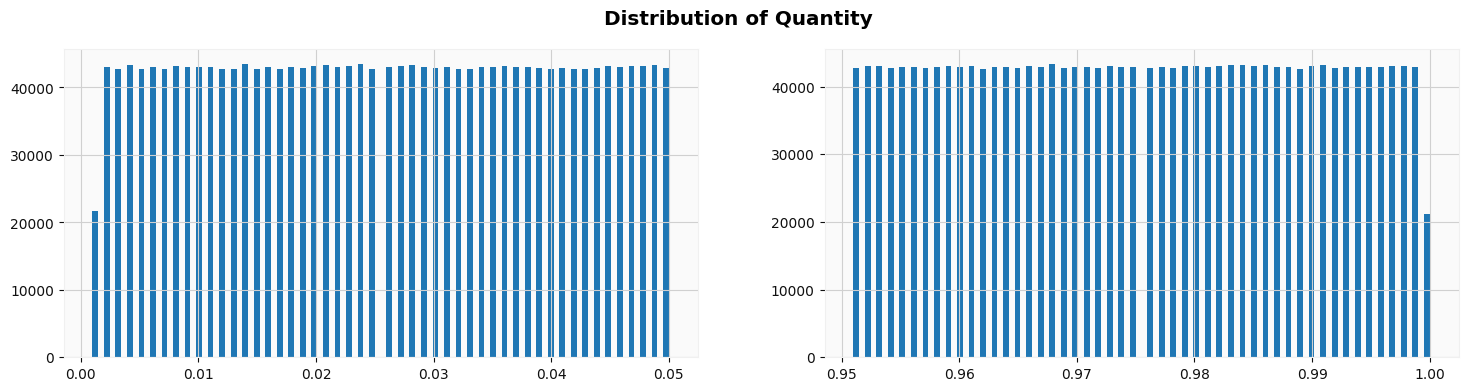

In [110]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 4))

pd_quantity = df.loc[:, "quantity"].compute()
_ = ax[0].hist(pd_quantity[pd_quantity < quantity_q.loc[0.05]], bins = 100)
_ = ax[1].hist(pd_quantity[pd_quantity > quantity_q.loc[0.95]], bins = 100)
fig.suptitle("Distribution of Quantity")

The same plot on execution time suggests that there the higher end of execution times have potential outliers, and deserves a deeper investigation.

Text(0.5, 0.98, 'Distribution of Execution Time')

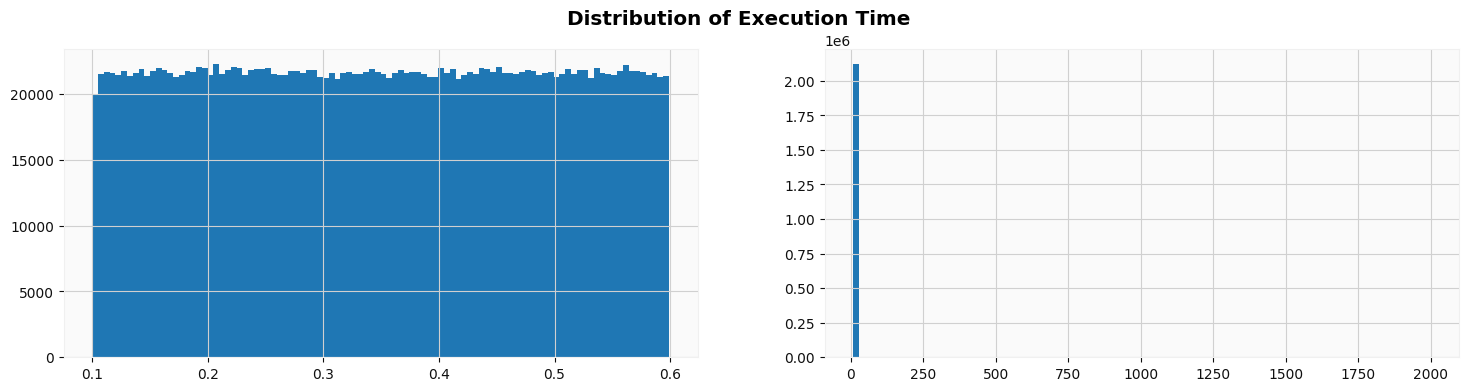

In [111]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 4))

pd_exectime = df.loc[:, "execution_time"].compute()
_ = ax[0].hist(pd_exectime[pd_exectime < exectime_q.loc[0.05]], bins = 100)
_ = ax[1].hist(pd_exectime[pd_exectime > exectime_q.loc[0.95]], bins = 100)
fig.suptitle("Distribution of Execution Time")

Further investigation shows that an execution time of 10ms sets a hard boundary on seemingly normal data, and outliers.
1. Execution time of less than or equal to 10ms seems to have a overall uniform histogram.
2. The shortest execution time once 10ms mark is passed is extremely high, at 1003.29.

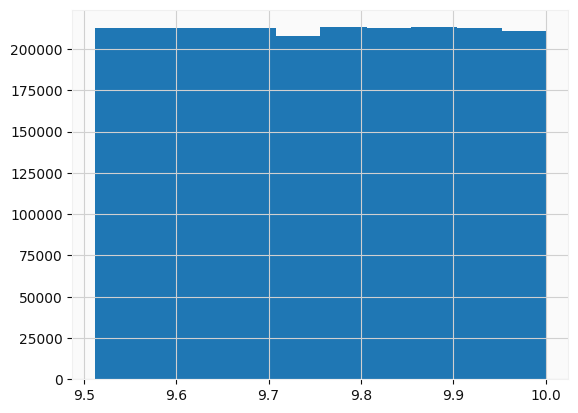

In [112]:
_ = plt.hist(pd_exectime[np.logical_and(pd_exectime > exectime_q.loc[0.95], pd_exectime <= 10)], width = 0.05)

In [113]:
print(pd_exectime[pd_exectime > 10].min())

1003.29


There are 500 of these "outlier" points, and all are occurring between 1000ms to 2000ms marks. Worth checking if the data points are errorneous.

In [114]:
outliers_exectime_bool = pd_exectime > 10
print(sum(outliers_exectime_bool))

500


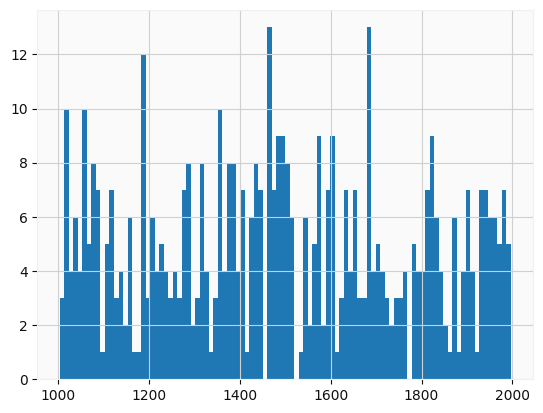

In [115]:
_ = plt.hist(pd_exectime[outliers_exectime_bool], bins = 100)

A quick check on jointly occurring outliers through a standardised Euclidean distance.

In [116]:
# Standardise the data
pd_std_quantity = (pd_quantity - pd_quantity.mean()) / pd_quantity.std()
pd_std_exectime = (pd_exectime - pd_exectime.mean()) / pd_exectime.std()

# Calculate Euclidean Distance from origin
radius = np.sqrt(pd_std_exectime ** 2 + pd_std_quantity ** 2)

Seems like there are no clear outliers jointly.

Text(0.5, 1.0, 'Outliers')

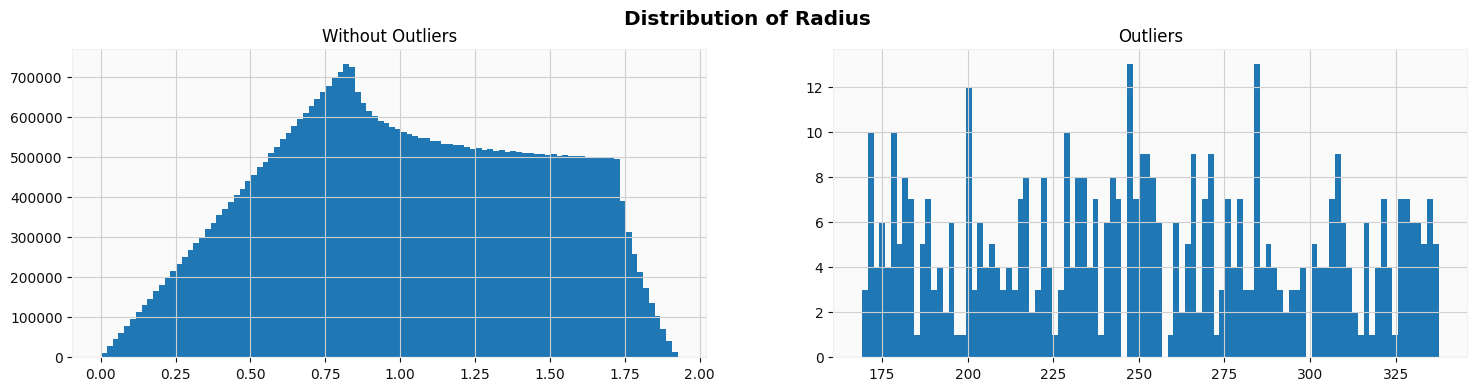

In [117]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 4))
_ = ax[0].hist(radius[~outliers_exectime_bool], bins = 100)
_ = ax[1].hist(radius[outliers_exectime_bool], bins = 100)
fig.suptitle("Distribution of Radius")
ax[0].set_title("Without Outliers")
ax[1].set_title("Outliers")

### (b.1) Compute average trade quantity

With or without Execution Time outlier points, the means of trade quantity are very similar

In [74]:
print(f"With Execution Time outlier samples: {pd_quantity.mean()}")
print(f"Without Execution Time outlier samples: {pd_quantity[~outliers_exectime_bool].mean()}")

With Execution Time outlier samples: 0.5004428456917266
Without Execution Time outlier samples: 0.5004429923921822


Further exploration shows quantity does not exhibit a perceptible trend.

<Axes: title={'center': 'Rolling Mean of Quantity'}, xlabel='timestamp'>

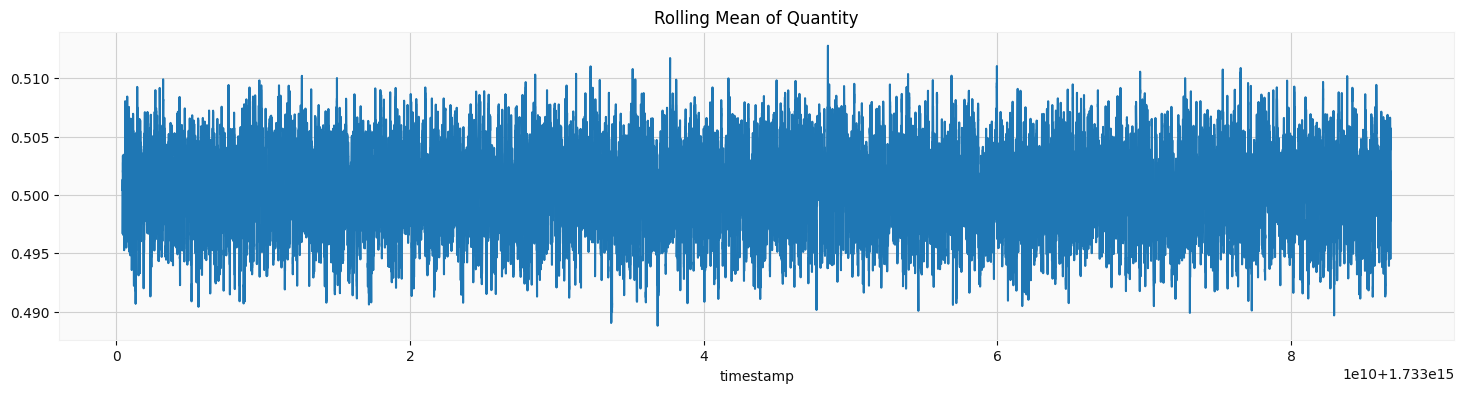

In [ ]:
pd_quantity_sorted = pd.Series(pd_quantity.values, index = df.loc[:, "timestamp"].compute()).sort_index()
pd_quantity_sorted.rolling(10_000).mean().plot(figsize = (18, 4), title = "Rolling Mean of Quantity")

### (b.2) Build a distribution of execution time per market

In [75]:
pd_market = df.loc[:, "market"].compute()

Outliers seems to be of similar counts across different markets.

In [76]:
pd_market[outliers_exectime_bool].value_counts()

market
BINANCE    170
HUOBI      166
KRAKEN     164
Name: count, dtype: int64

Remove outliers

In [77]:
pd_market_exout = pd_market[~outliers_exectime_bool]
pd_exectime_exout = pd_exectime[~outliers_exectime_bool]

In [80]:
f = open('outliers_exectime_bool.pkl','wb')
pickle.dump(outliers_exectime_bool, f)
f.close()

Splitting into different markets

In [81]:
sample_bin = pd_exectime_exout[pd_market_exout == "BINANCE"]
sample_huo = pd_exectime_exout[pd_market_exout == "HUOBI"]
sample_kra = pd_exectime_exout[pd_market_exout == "KRAKEN"]

All markets seem to have very similar distributions. Initial guess would be (for each market) $$Unif~[0, 10]$$

<Axes: title={'center': 'KRAKEN'}, ylabel='Frequency'>

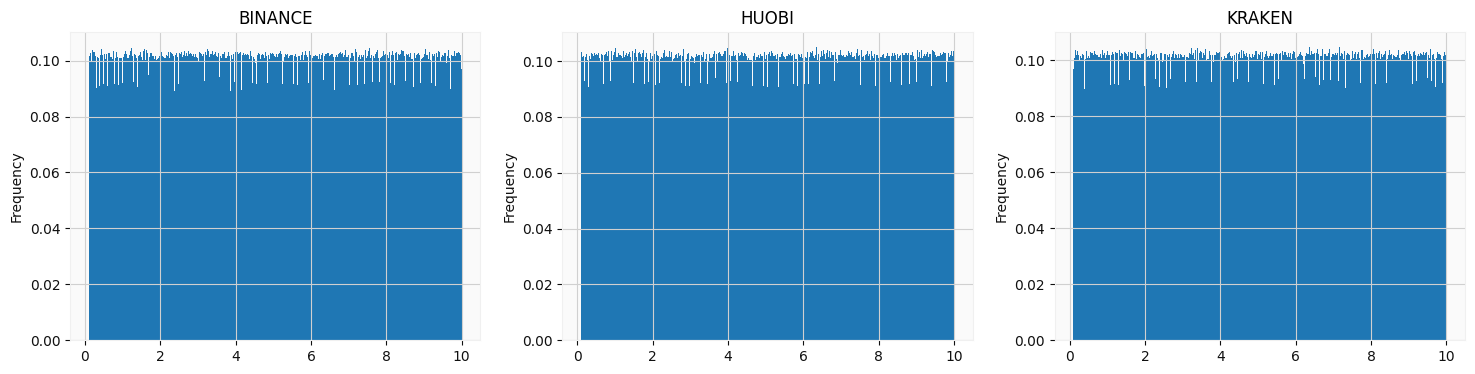

In [82]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (18, 4))
sample_bin.plot(kind = "hist", bins = 1000, density = True, ax = ax[0], title = "BINANCE")
sample_huo.plot(kind = "hist", bins = 1000, density = True, ax = ax[1], title = "HUOBI")
sample_kra.plot(kind = "hist", bins = 1000, density = True, ax = ax[2], title = "KRAKEN")

Plotting random samples of data from each market against a $ Unif~[0, 10] $ distribution yields a great qqplot.  
Running Kolgomorov-Smirkov test against a uniform distribution also returns insignificant test results, at 10% significance level.  
We shall accept the premise that there are insufficient evidence that the execution time per market is not uniformly distributed.

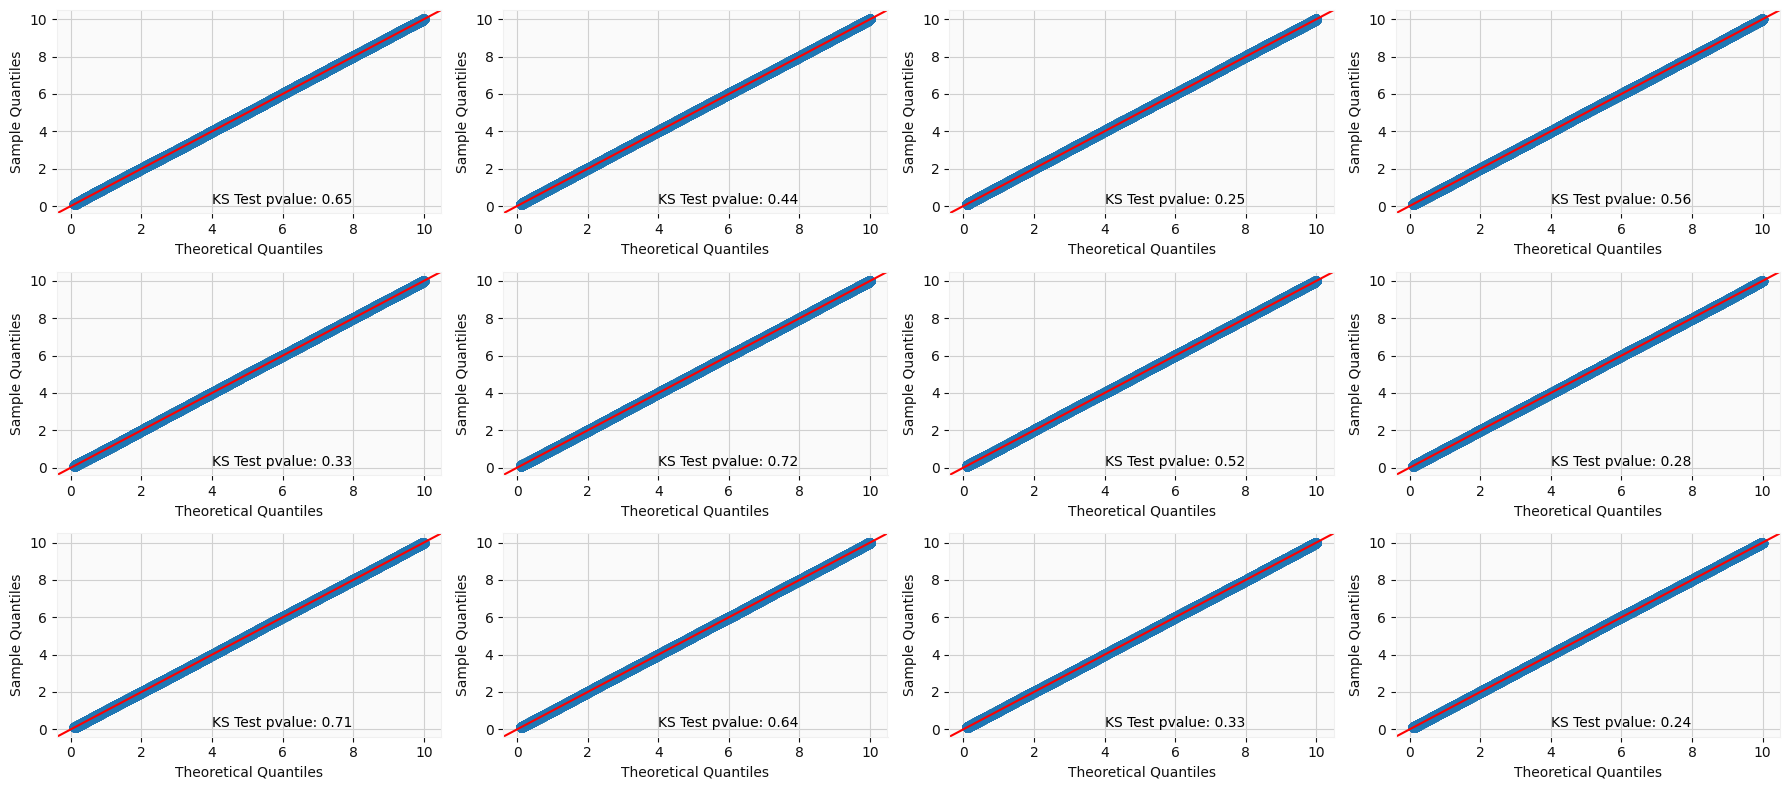

In [83]:
fig, ax = plt.subplots(nrows = 3, ncols = 4, figsize = (18, 8))

for i, sample in enumerate([sample_bin, sample_huo, sample_kra]):
    for j in range(4):
        s = sample.sample(100_000, random_state = j)
        sm.qqplot(s, dist = stats.distributions.uniform, loc = sample.min(), scale = sample.max() - sample.min(), line = '45', ax = ax[i, j])
        ax[i, j].text(4, 0.1, f"KS Test pvalue: {round(stats.kstest(s, stats.distributions.uniform(loc = sample.min(), scale = sample.max() - sample.min()).cdf).pvalue, 2)}")

fig.tight_layout()

Clear heavy data

In [ ]:
del pd_exectime, pd_exectime_exout, pd_market, pd_market_exout, pd_quantity, pd_std_exectime, pd_std_quantity, radius, pd_quantity_sorted

### (c) Aggregate into  10-minute OHLC and volume data

In [ ]:
stick_size = 10 * 60 * 1e6 # 10 minutes in microseconds

Group data into 10-minute bars

In [95]:
grouped = df\
    .assign(stick_num = lambda x: x.loc[:, "timestamp"] // stick_size)\
    .sort_values(by = ["timestamp"])\
    .groupby(["market", "pair", "stick_num"]).agg(
        Open = ("price", "first"),
        High = ("price", "max"),
        Low = ("price", "min"),
        Close = ("price", "last"),
        Volume = ("quantity", "sum")
    ).compute()

Write a function to convert each candlestick into a real datetime. Here we assume that the timestamp = 0 represents 1970-01-01 00:00:00.000000

In [96]:
def sticknum_to_datetime(stick_num, start_datetime, start_sticknum):
    return start_datetime + timedelta(minutes = int((stick_num - start_sticknum) * 10))

C:\Users\Jian\AppData\Local\Temp\ipykernel_9264\1196772540.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  bin_btc = grouped.loc[("BINANCE", "BTC_USDT"), :]


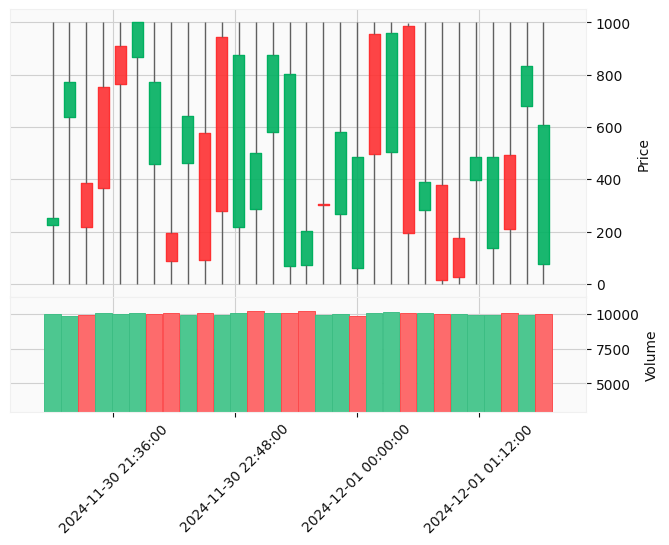

In [104]:
bin_btc = grouped.loc[("BINANCE", "BTC_USDT"), :]
bin_btc.index = bin_btc.index.to_series().apply(sticknum_to_datetime, start_datetime = datetime(1970, 1, 1), start_sticknum = 0).astype("datetime64[ns]")

mpf.plot(
    bin_btc.dropna(subset = ["Close"]).sort_index()[:30],
    type = "candle",
    style = "yahoo",
    volume = True,
    show_nontrading = True,
    datetime_format = "%Y-%m-%d %H:%M:%S"
)